# Importing Packages

In [1]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Importing

In [4]:
data_dir = "/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers


/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers/C54/C54_73_augmented_3.jpg


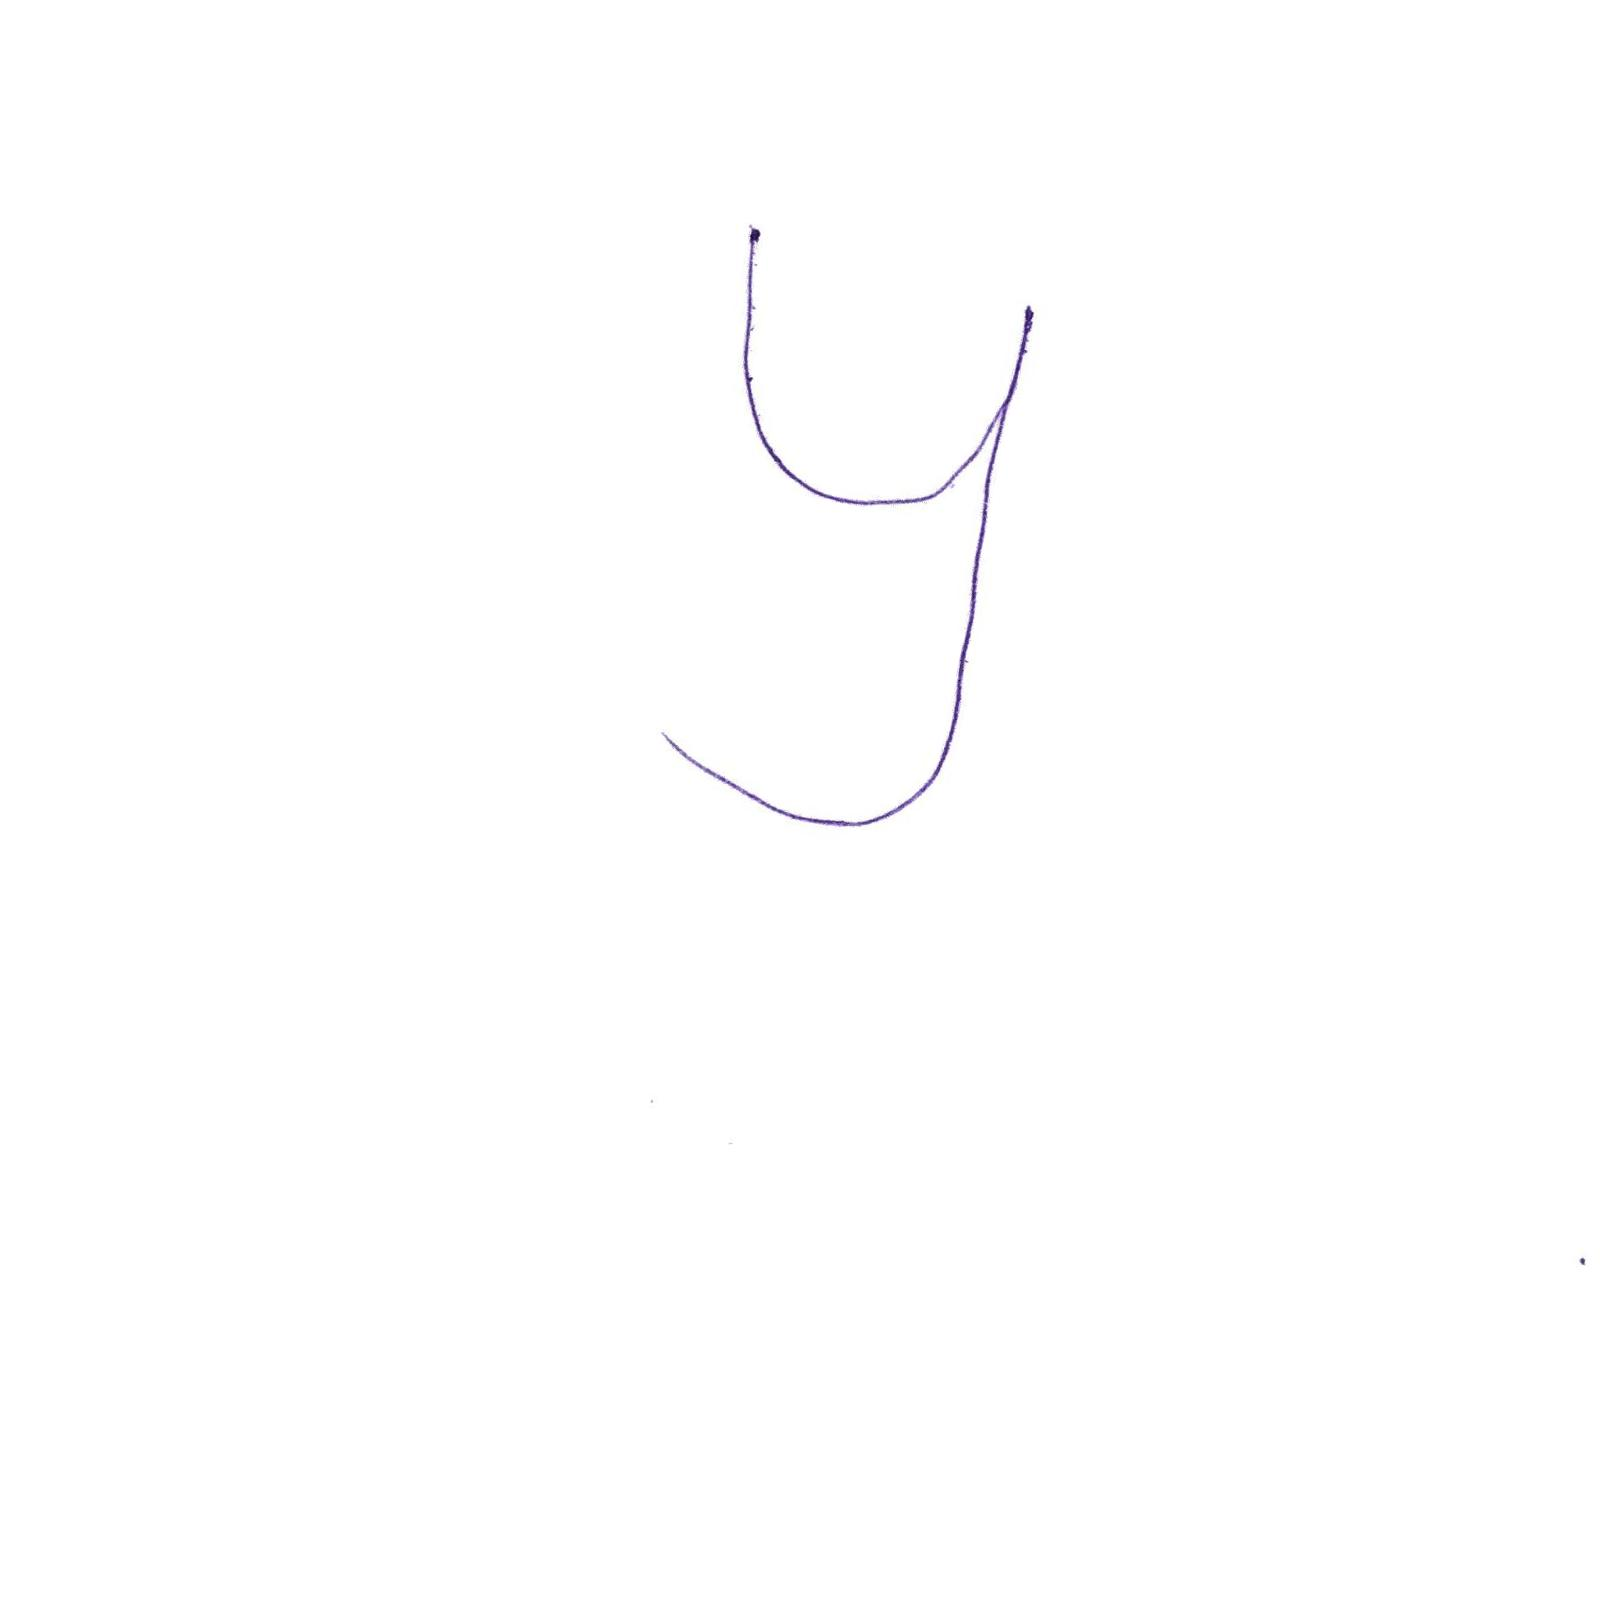

In [5]:
ch1 = list(data_dir.glob('C54/*'))
print(ch1[0])
PIL.Image.open(str(ch1[0]))

# Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height,img_width=224,224
batch_size =32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

# Prepare training dataset with data augmentation
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Prepare validation dataset without data augmentation
val_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 4500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [8]:
class_indices = train_ds.class_indices
class_names = {v: k for k, v in class_indices.items()}
print(class_names)

{0: 'C49', 1: 'C50', 2: 'C51', 3: 'C52', 4: 'C53', 5: 'C54', 6: 'C55', 7: 'C56', 8: 'C57', 9: 'C58'}


# Develop Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Load ResNet50
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Model modification
model = Sequential([
    base_model,    
    # Here, we introduce additional  layers.
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add additional Conv2D layer
    BatchNormalization(),  # Add BatchNormalization layer
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, activation="relu"),  # A dense layer with 1024 units and 'relu' activation.
    Dropout(0.5),                     # A dropout layer for regularization (optional).
    Dense(512, activation="relu"),   # Another dense layer with 512 units.
    Dropout(0.5),                     # Another dropout layer for regularization (optional).
    
    Dense(len(train_ds.class_indices), activation="softmax")
])

# Define the learning rate
learning_rate = 0.001  # You can adjust this value as needed

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         4718848   
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 256)         0         
                                                                 
 global_average_pooling2d_1  (None, 256)              

# Train Model

In [53]:
# creating checkpoints
model_path = "/kaggle/working/MNCR_best_model_M3_V1.keras"

# Define the checkpoint
checkpoint = ModelCheckpoint(model_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


In [54]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint]   
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9993
Epoch 1: val_accuracy improved from -inf to 0.98800, saving model to /kaggle/working/MNCR_best_model_M3_V1.keras
141/141 [==============================] - 56s 400ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0551 - val_accuracy: 0.9880
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9964
Epoch 2: val_accuracy did not improve from 0.98800
141/141 [==============================] - 55s 391ms/step - loss: 0.0180 - accuracy: 0.9964 - val_loss: 0.1944 - val_accuracy: 0.9493
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9884
Epoch 3: val_accuracy did not improve from 0.98800
141/141 [==============================] - 55s 390ms/step - loss: 0.0535 - accuracy: 0.9884 - val_loss: 87.5926 - val_accuracy: 0.1000
Epoch 4/20
141/141 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.994

# Model Evaluation

In [55]:
from tensorflow.keras.models import load_model
best_model = load_model('/kaggle/working/MNCR_best_model_M3_V1.keras')

In [56]:
test_dir = '/kaggle/input/testingdataset/Numbers'

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 400 images belonging to 10 classes.


In [57]:
result = best_model.evaluate(test_data)
print(result)

13/13 [==============================] - 3s 126ms/step - loss: 0.8014 - accuracy: 0.9175
[0.8014340400695801, 0.9175000190734863]


In [58]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the testing dataset
y_pred = best_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the validation dataset generator
val_true_labels = test_data.classes

# Convert one-hot encoded labels to class labels
val_class_labels = list(val_ds.class_indices.keys())

# Generate classification report
classification_rep = classification_report(val_true_labels, y_pred_classes, target_names=val_class_labels)

print("Classification Report:")
print(classification_rep)

13/13 [==============================] - 2s 86ms/step
Classification Report:
              precision    recall  f1-score   support

         C49       0.05      0.05      0.05        40
         C50       0.11      0.07      0.09        40
         C51       0.11      0.10      0.11        40
         C52       0.09      0.10      0.09        40
         C53       0.05      0.05      0.05        40
         C54       0.06      0.05      0.05        40
         C55       0.13      0.20      0.16        40
         C56       0.24      0.25      0.24        40
         C57       0.08      0.07      0.08        40
         C58       0.13      0.12      0.13        40

    accuracy                           0.11       400
   macro avg       0.10      0.11      0.10       400
weighted avg       0.10      0.11      0.10       400



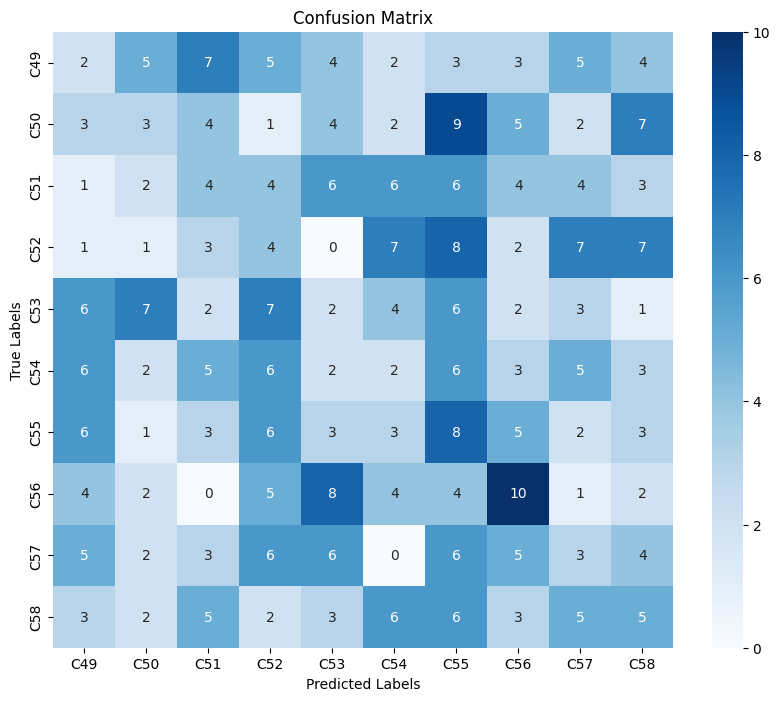

In [59]:
# Confusion Matrix


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_labels, yticklabels=val_class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
